# Tesing multi group permutation

In the case of dependencies between observations during a 2 sample test, we hold fixed their relative labels during the permutation. 

Here, we simulate pairs of observations more similar to one another than others. We form two sets of labels in the two sample test. In the "null" case, we are pair agnostic. Otherwise, either the pairs are assigned:
- the same label (differences **across**)
- different labels (differences **within**)

Followng the simulations, the scipy permutation code is validated and we see that the permutations sort pairs correctly while the "null" permutation case shows no pattern.

In [1]:
import sys, os
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
%matplotlib inline

sys.path.append(os.path.realpath('..'))
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from scipy.spatial.distance import squareform, pdist
from scipy.stats import multiscale_graphcorr
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
def simulate_2sample_null(n1, n2, m1, m2, d, group_std, group_structure, seed=None):
    """
    n1,n2 : number of groups in each of the 2 samples
    m1,m2 : size of groups in each sample. If group_structure is 'within', must be
            a length 2 tuple giving the number of observations in correpsondingly indexed sample
            and the number of observations in the other sample, respectively.
    d : dimension of observations
    group_std : standard deviation of normal distribution for each group around group mean
    group_structure : one of {'within', 'across'}. 'within' allows permutations of labels in each
                        group. 'across permutes group labels together'.
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is not None:
        mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    if group_structure == 'across' or group_structure == 'full':
        X = np.vstack(
            [np.random.normal(mu,group_std,(m1,d)) for mu in mus1]  +
            [np.random.normal(mu,group_std,(m2,d)) for mu in mus2]
        )
        Y = np.hstack(([0]*n1*m1, [1]*n2*m2))
        groups = np.hstack(
            [[f'{i}']*m1 for i in range(n1)] +
            [[f'{i}']*m2 for i in range(n2)]
        )
    elif group_structure == 'within':
        X = np.vstack([np.random.normal(mu,group_std,(m1+m2,d)) for mu in mus1])
        Y = np.hstack([[0]*m1 + [1]*m2 for _ in range(n1)])
        groups = np.hstack([[f'{i}']*(m1+m2) for i in range(n1)])
    else:
        print('Invalid group_structure inpute')
        
    return X, Y, groups

In [22]:
n1 = 29
n2 = 47
d = 100
group_std = 0.1
test_list = [
    ('Experts rest vs. novices compassion', n1, n2 , 1, 1, 'full'),
    ('Experts rest vs. experts compassion', n1, None, 1, 1, 'within'),
    ('Experts rest vs. experts meditating', n1, None, 1, 2, 'within'),
    ('Experts meditating vs. novices meditating', n1, n2, 2, 2, 'across'),
    ('Experts all vs. novices all', n1, n2 ,3 ,3 , 'across'),
]

In [24]:
n_datasets = 500
test_results = defaultdict(list)
for test, n1, n2, m1, m2, group_structure in test_list:
    print(test)
    for i in range(n_datasets):
        if i % 100 == 0:
            print(i)
        X, Y, groups = simulate_2sample_null(n1, n2, m1, m2, d, group_std, group_structure, seed=i)
        stat,pval,mgc_dict = multiscale_graphcorr(
            X,Y,
            reps=100,
            workers=-1,
            random_state=1,
            permute_groups=groups,
            permute_structure=group_structure,
            global_corr='mgc_restricted',
        )
        test_results[test].append(pval)

Experts rest vs. experts compassion
0
100
200
300
400
Experts rest vs. experts meditating
0
100
200
300
400
Experts meditating vs. novices meditating
0
100
200
300
400
Experts all vs. novices all
0
100
200
300
400


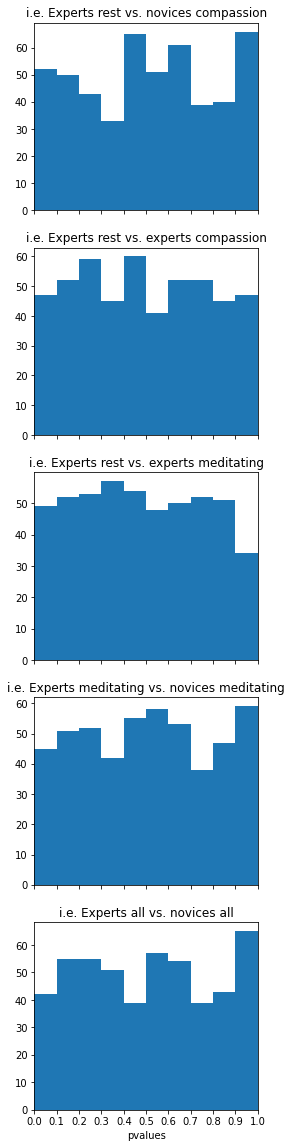

In [26]:
fig, axes = plt.subplots(len(test_results.keys()),1,sharex=True, figsize=(4, 4*len(test_results.keys())))
for ax,test in zip(axes, test_results.keys()):
    ax.hist(test_results[test], bins = np.arange(0,1.1,0.1))
    ax.set_title(f'i.e. {test}')
    ax.set_xlim(0,1)
for ax in axes[:-1]:
    ax.set_xticks([])
axes[-1].set_xlabel('pvalues')
axes[-1].set_xticks(np.arange(0,1.1,0.1))
#fig.suptitle('Distribution of simulated pvalues under restricted permutations', y=0.89)
plt.show()

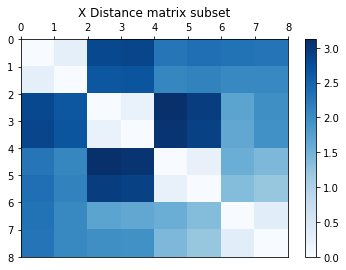

In [3]:
data = squareform(pdist(datasets[0][:8]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('X Distance matrix subset')
plt.show()

### Across classes

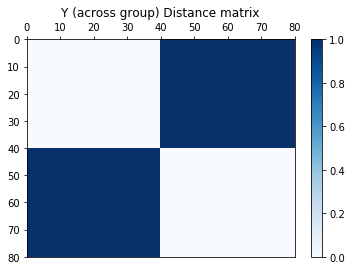

In [4]:
data = squareform(pdist(Y_across[:,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (across group) Distance matrix')
plt.show()

In [5]:
pvalues_across_uc = []
for X in datasets:
    stat_uc, pval_uc = Dcorr().test(
        X,Y_across,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=np.arange(Y_across.shape[0]),
        permute_structure='full'
    )
    pvalues_across_uc.append(pval_uc)

Text(0, 0.5, 'n')

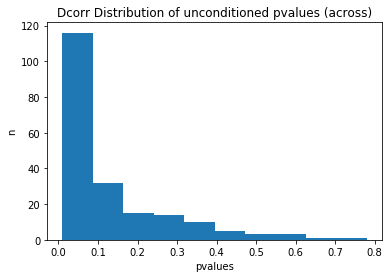

In [6]:
plt.hist(pvalues_across_uc)
plt.title('Dcorr Distribution of unconditioned pvalues (across)')
plt.xlabel('pvalues')
plt.ylabel('n')

In [14]:
pvalues_across_c = []
for X in datasets:
    stat_c, pval_c = Dcorr().test(
        X,Y_across,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=groups,
        permute_structure='across'
    )
    pvalues_across_c.append(pval_c)

Text(0, 0.5, 'n')

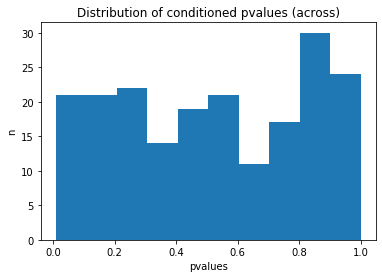

In [15]:
plt.hist(pvalues_across_c)
plt.title('Distribution of conditioned pvalues (across)')
plt.xlabel('pvalues')
plt.ylabel('n')

### Within class

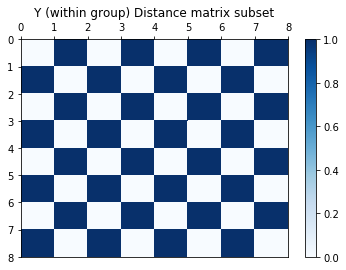

In [9]:
data = squareform(pdist(Y_within[:8,None]))
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)
plt.colorbar(heatmap)
# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()
plt.title('Y (within group) Distance matrix subset')
plt.show()

In [10]:
pvalues_within_uc = []
for X in datasets:
    stat_uc, pval_uc = Dcorr().test(
        X,Y_within,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=np.arange(Y_across.shape[0]),
        permute_structure='full'
    )
    pvalues_within_uc.append(pval_uc)

Text(0, 0.5, 'n')

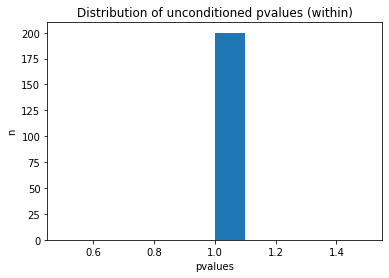

In [11]:
plt.hist(pvalues_within_uc)
plt.title('Distribution of unconditioned pvalues (within)')
plt.xlabel('pvalues')
plt.ylabel('n')

In [34]:
pvalues_within_c = []
for X in datasets:
    stat_c, pval_c = Dcorr().test(
        X,Y_within,
        reps=100,
        workers=-1,
        auto=False,
        permute_groups=groups,
        permute_structure='within'
    )
    pvalues_within_c.append(pval_c)

Text(0, 0.5, 'n')

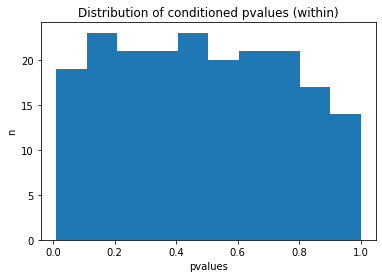

In [35]:
plt.hist(pvalues_within_c)
plt.title('Distribution of conditioned pvalues (within)')
plt.xlabel('pvalues')
plt.ylabel('n')

## Test Permutation null

In [30]:
def _center_distmat(distx, bias):  # pragma: no cover
    """Centers the distance matrices"""
    n = distx.shape[0]

    # double centered distance matrices
    if bias:
        # use sum instead of mean because of numba restrictions
        exp_distx = (
            np.repeat(distx.sum(axis=0) / n, n).reshape(-1, n).T
            + np.repeat(distx.sum(axis=1) / n, n).reshape(-1, n)
            - (distx.sum() / (n * n))
        )
    else:
        exp_distx = (
            np.repeat((distx.sum(axis=0) / (n - 2)), n).reshape(-1, n).T
            + np.repeat((distx.sum(axis=1) / (n - 2)), n).reshape(-1, n)
            - distx.sum() / ((n - 1) * (n - 2))
        )
    cent_distx = distx - exp_distx
    if not bias:
        np.fill_diagonal(cent_distx, 0)

    return cent_distx


def _dcorr(distx, disty, bias):  # pragma: no cover
    """Calculate the Dcorr test statistic"""
    # center distance matrices
    cent_distx = _center_distmat(distx, bias)
    cent_disty = _center_distmat(disty, bias)

    # calculate covariances and variances
    covar = np.sum(np.multiply(cent_distx, cent_disty.T))
    varx = np.sum(np.multiply(cent_distx, cent_distx.T))
    vary = np.sum(np.multiply(cent_disty, cent_disty.T))

    # stat is 0 with negative variances (would make denominator undefined)
    if varx <= 0 or vary <= 0:
        stat = 0

    # calculate generalized test statistic
    else:
        stat = covar / np.real(np.sqrt(varx * vary))

    return stat

def _distmat(x):
    if len(np.asarray(x).shape) == 1:
        x = np.asarray(x)[:,None]
    return squareform(pdist(x))

# permutation group shuffling class
class _PermGroups(object):
    """
    Helper function to calculate parallel p-value.
    """
    def __init__(self, y, permute_groups=None, permute_structure=None):
        self.permute_groups = permute_groups
        self.permute_structure = permute_structure
        self.y_labels = np.unique(y, return_inverse=True, axis=1)[1]
        if permute_structure == 'within':
            self.group_indices = defaultdict(list)
            for i,group in enumerate(permute_groups):
                self.group_indices[group].append(i)
        elif permute_structure == 'across':
            # dict: [y_label] -> list(indices)
            self.class_indices = defaultdict(list) 
            group_indices = defaultdict(list)
            for i,(group,label) in enumerate(zip(permute_groups, self.y_labels)):
                self.class_indices[label].append(i)
                group_indices[group].append(i)
            # list of group indices, sorted descending order
            self.group_indices = sorted(
                group_indices.values(), key=lambda x: len(x), reverse=True
            )

    def __call__(self):
        if self.permute_groups is None or self.permute_structure=='full':
            order = np.random.permutation(self.y_labels.shape[0])
        elif self.permute_structure == 'within':
            old_indices = np.hstack(self.group_indices.values())
            new_indices = np.hstack([np.random.permutation(idx) for idx in self.group_indices.values()])
            order = np.ones(self.y_labels.shape[0]) * -1
            order[np.asarray(old_indices)] = new_indices
            order = order.astype(int)
        elif self.permute_structure == 'across':
            # Copy dict: [y_label] -> list(indices)
            class_indices_copy = deepcopy(self.class_indices)
            new_indices = []
            old_indices = []
            p0 = len(class_indices_copy[0])
            p1 = int(len(class_indices_copy[1]) / 2)
            for group in self.group_indices:
                #p0 = self.factorial(len(class_indices_copy[0]), len(group))
                #p1 = self.factorial(len(class_indices_copy[1]), len(group))
                # New indices sampled per probabilities at that step
                if np.random.uniform() < p0 / (p0+p1):
                    new_indices += [class_indices_copy[0][0] for _ in range(len(group))]
                    p0 -= 1
                else:
                    new_indices += [class_indices_copy[1][1] for _ in range(len(group))]
                    p1 -= 1
                # Old indices in correct order
                old_indices += group
            order = np.ones(self.y_labels.shape[0]) * -1
            order[np.asarray(old_indices)] = new_indices
            order = order.astype(int)
        else:
            msg = "permute_structure must be of {'full', 'within', 'across'}"
            raise ValueError(msg)

        return order

    def factorial(self, n, n_mults):
        if n_mults == 0:
            return 1
        else:
            return n * self.factorial(n-1, n_mults-1)

In [28]:
n = 40
d = 18715
n_datasets = 100

# i.e. Novices resting vs. Experts meditating
datasets_across_12 = []
n1 = 47
n2 = 29
m1 = 1
m2 = 2
for i in range(n_datasets):
    np.random.seed(i)
    mus1 = np.random.normal(0,1,(n1,d))
    mus2 = np.random.normal(0,1,(n2,d))
    X = np.vstack(
        [np.random.normal(mu,0.1,(m1,d)) for mu in mus1]  +
        [np.random.normal(mu,0.1,(m2,d)) for mu in mus2]
    )
    datasets_across_12.append(X)
Y_across_12 = np.hstack((
    [0]*n1*m1,
    [1]*n2*m2
))
groups_across_12 = np.hstack(
    [[f'{i}']*m1 for i in range(n1)] +
    [[f'{i}']*m2 for i in range(n2)]
)

In [32]:
pvalues = []
disty = _distmat(Y_across_12)
for X in datasets_across_12:
    distx = _distmat(X)
    stat = _dcorr(distx, disty, bias=False)
    pg = _PermGroups(disty, permute_groups=groups_across_12, permute_structure='across')
    null_stats = []
    for _ in range(100):
        order = pg()
        null_stats.append(_dcorr(distx, disty[order][:, order], bias=False))
    pvalues.append(np.mean(np.asarray(null_stats) <= stat))
    pvalues.append(pval)

Text(0, 0.5, 'n')

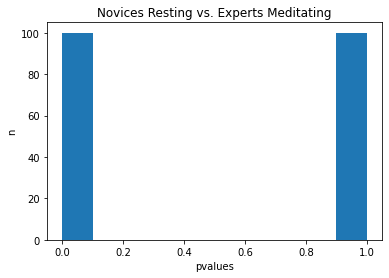

In [33]:
plt.hist(pvalues)
plt.title('Novices Resting vs. Experts Meditating')
plt.xlabel('pvalues')
plt.ylabel('n')

## Effect of dimension on test stat value

In [14]:
def simulate_2sample_null(n1, n2=None, d=100, group_std=0.1, seed=None):
    """
    Simulates a set of paired observations for a 2-sample test.
    
    n1,n2 : size of the two groups. Are both n1 if n2 is None
    d : dimension of observations
    group_std : standard deviation of normal distribution around group mean
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is None:
        n2 = n1
    mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    X = np.vstack(
        [np.random.normal(mu, group_std, (2,d)) for mu in mus1]  +
        [np.random.normal(mu, group_std, (2,d)) for mu in mus2]
    )        
    return X

In [37]:
n1 = 29
n2 = 47
dimensions = [5,10,50,100,1000,5000,10000]
n_runs = 10
group_std = 0.1

# Labels
Y_within = np.asarray([0, 1] * (n1+n2))

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n1+n2)]).T

In [ ]:
stat_results = []
pval_results = []

In [30]:
for d in dimensions:
    print(d)
    stat_list = []
    pval_list = []
    for i in range(n_runs):
        X = simulate_2sample_null(n1, n2, d, group_std, seed=i)
        stat, pval = Dcorr().test(
            X,
            Y_within,
            reps=1,
            workers=1,
            auto=False,
            perm_blocks=blocks_within,
        )
        stat_list.append(stat)
        pval_list.append(pval)
    stat_results.append(stat_list)
    pval_results.append(pval_list)

5000
10000


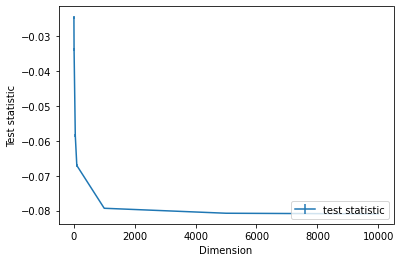

In [46]:
fig = plt.figure()

y = [np.mean(r) for r in stat_results]
yerr = [np.std(r) for r in stat_results]
plt.errorbar(dimensions, y, yerr=yerr, label='test statistic')

plt.xlabel('Dimension')
plt.ylabel('Test statistic')
plt.legend(loc='lower right')
plt.show()

In [47]:
n1 = 38
n2 = 38
dimensions = [5,10,50,100,1000,5000,10000]
n_runs = 10
group_std = 0.1

# Labels
Y_within = np.asarray([0, 1] * (n1+n2))

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n1+n2)]).T

stat_results = []
pval_results = []

In [48]:
for d in dimensions:
    print(d)
    stat_list = []
    pval_list = []
    for i in range(n_runs):
        X = simulate_2sample_null(n1, n2, d, group_std, seed=i)
        stat, pval = Dcorr().test(
            X,
            Y_within,
            reps=1,
            workers=1,
            auto=False,
            perm_blocks=blocks_within,
        )
        stat_list.append(stat)
        pval_list.append(pval)
    stat_results.append(stat_list)
    pval_results.append(pval_list)

5
10
50
100
1000
5000
10000


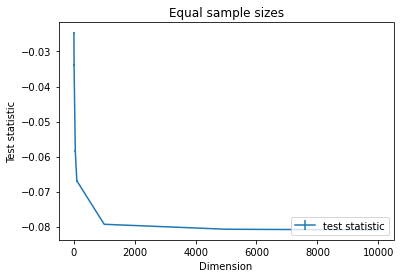

In [49]:
fig = plt.figure()

y = [np.mean(r) for r in stat_results]
yerr = [np.std(r) for r in stat_results]
plt.errorbar(dimensions, y, yerr=yerr, label='test statistic')

plt.xlabel('Dimension')
plt.ylabel('Test statistic')
plt.title('Equal sample sizes')
plt.legend(loc='lower right')
plt.show()